## Bike Sharing Assignment

Building a multiple linear regression model for the prediction of demand for shared bikes.

In [1]:
# Import Libraries required for EDA, model building and evaluation

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("day.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [6]:
# dropping casual and registered as they are just the numbers which as divided as part of cnt

In [7]:
df = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

In [8]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


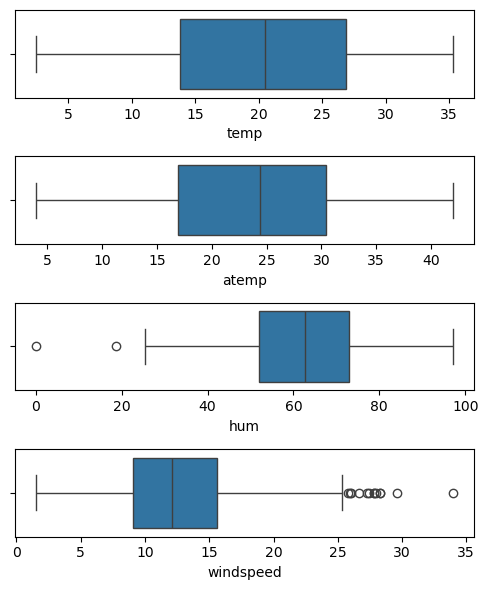

In [9]:
fig, subs = plt.subplots(4, figsize=(5, 6))
sns.boxplot(df.temp, ax = subs[0], orient='h')
sns.boxplot(df.atemp, ax = subs[1], orient='h')
sns.boxplot(df.hum, ax = subs[2], orient='h')
sns.boxplot(df.windspeed, ax = subs[3], orient='h')
plt.tight_layout()

In [10]:
q1 = df.hum.quantile(.25)
q3 = df.hum.quantile(.75)
iqr = q3 - q1
lb = q1 - 2 * iqr
ub = q3 + 2 * iqr
print(lb, ub)

10.020849999999996 114.968725


In [11]:
df[df.hum==0]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
68,1,0,3,0,4,1,3,15.952731,19.2834,0.0,17.545759,623


In [12]:
df.hum[df.hum==0.0] = df.hum.quantile(0.5) # seems like hum value is not updated, filling with median value

In [13]:
q1 = df.windspeed.quantile(.25)
q3 = df.windspeed.quantile(.75)
iqr = q3 - q1
lb = q1 - 2 * iqr
ub = q3 + 2 * iqr
print(lb, ub)

-4.1262285 28.79346775


In [14]:
df[df.windspeed > ub]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
49,1,0,2,0,6,0,1,16.365847,19.5702,18.7917,34.000021,1635
431,1,1,3,0,4,1,1,21.627500,26.2302,56.7500,29.584721,5382


In [15]:
# no fix needed for windspeed, outliers look fine

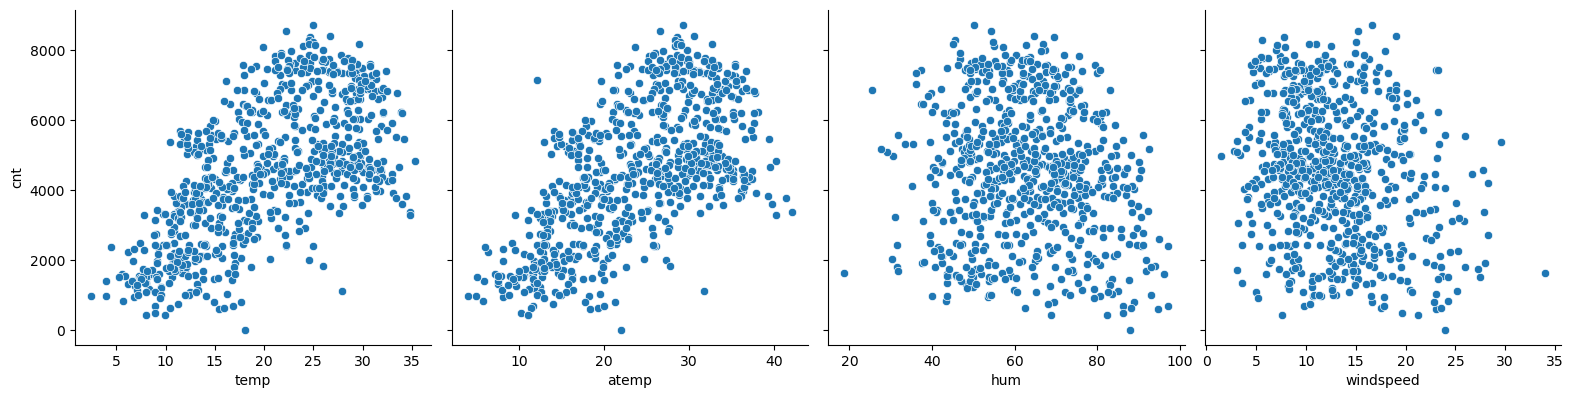

In [16]:
sns.pairplot(df, x_vars=['temp', 'atemp', 'hum', 'windspeed'], y_vars='cnt', height=4, aspect=1, kind='scatter')
plt.show()

There seems to be some co-relation between temp/atemp and cnt

In [17]:
df.season.value_counts()

season
3    188
2    184
1    180
4    178
Name: count, dtype: int64

In [18]:
def convert_to_season_name(x):
    return {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}[x];

df.season = df.season.apply(convert_to_season_name)

In [19]:
df.weathersit.value_counts()

weathersit
1    463
2    246
3     21
Name: count, dtype: int64

In [20]:
def convert_to_weather_situation(x):
    return {1: 'clear', 2: 'cloudy', 3: 'rain'}[x];

df.weathersit = df.weathersit.apply(convert_to_weather_situation)

In [21]:
df.mnth.value_counts()

mnth
1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     56
Name: count, dtype: int64

In [22]:
def convert_to_months(x):
    return {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',7: 'July',
            8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}[x];

df.mnth = df.mnth.apply(convert_to_months)

In [23]:
df.weekday.value_counts()

weekday
6    105
0    105
1    105
2    104
4    104
5    104
3    103
Name: count, dtype: int64

In [24]:
def convert_to_week_days(x):
    return {0: 'Tuesday', 1: 'Wednesday', 2: 'Thursday', 3: 'Friday', 4: 'Saturday', 5: 'Sunday', 6: 'Monday'}[x];

df.weekday = df.weekday.apply(convert_to_week_days)

In [25]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,January,0,Monday,0,cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,January,0,Tuesday,0,cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,January,0,Wednesday,1,clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,January,0,Thursday,1,clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,January,0,Friday,1,clear,9.305237,11.46350,43.6957,12.522300,1600


In [26]:
seasons = pd.get_dummies(df.season).astype('int')

In [27]:
seasons = seasons.drop('winter', axis=1)

In [28]:
seasons

,fall,spring,summer
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
725,0,1,0
726,0,1,0
727,0,1,0
728,0,1,0


In [29]:
weathers = pd.get_dummies(df.weathersit).astype('int')

In [30]:
weathers = weathers.drop('cloudy', axis=1)

In [31]:
weathers

,clear,rain
0,0,0
1,0,0
2,1,0
3,1,0
4,1,0
...,...,...
725,0,0
726,0,0
727,0,0
728,1,0


In [32]:
months = pd.get_dummies(df.mnth).astype('int')

In [33]:
months = months.drop('November', axis=1)

In [34]:
months

,April,August,December,February,January,July,June,March,May,October,September
0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
725,0,0,1,0,0,0,0,0,0,0,0
726,0,0,1,0,0,0,0,0,0,0,0
727,0,0,1,0,0,0,0,0,0,0,0
728,0,0,1,0,0,0,0,0,0,0,0


In [35]:
weekdays = pd.get_dummies(df.weekday).astype('int')

In [36]:
weekdays = weekdays.drop('Thursday', axis=1)

In [37]:
weekdays

,Friday,Monday,Saturday,Sunday,Tuesday,Wednesday
0,0,1,0,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
725,0,0,1,0,0,0
726,0,0,0,1,0,0
727,0,1,0,0,0,0
728,0,0,0,0,1,0


In [38]:
df = pd.concat([df, seasons, weathers, weekdays, months], axis=1)

In [39]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,August,December,February,January,July,June,March,May,October,September
0,spring,0,January,0,Monday,0,cloudy,14.110847,18.18125,80.5833,...,0,0,0,1,0,0,0,0,0,0
1,spring,0,January,0,Tuesday,0,cloudy,14.902598,17.68695,69.6087,...,0,0,0,1,0,0,0,0,0,0
2,spring,0,January,0,Wednesday,1,clear,8.050924,9.47025,43.7273,...,0,0,0,1,0,0,0,0,0,0
3,spring,0,January,0,Thursday,1,clear,8.200000,10.60610,59.0435,...,0,0,0,1,0,0,0,0,0,0
4,spring,0,January,0,Friday,1,clear,9.305237,11.46350,43.6957,...,0,0,0,1,0,0,0,0,0,0


In [40]:
df = df.drop(['season', 'weathersit', 'mnth', 'weekday'], axis=1)

In [41]:
df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,fall,spring,...,August,December,February,January,July,June,March,May,October,September
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,1,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,1,...,0,0,0,1,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,1,...,0,0,0,1,0,0,0,0,0,0


In [42]:
df_train, df_test = train_test_split(df, train_size=0.7, random_state=90)

In [43]:
df_train.shape

(510, 30)

In [44]:
df_test.shape

(220, 30)

In [45]:
scaler = MinMaxScaler()
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [46]:
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,fall,spring,...,August,December,February,January,July,June,March,May,October,September
352,0,0,1,0.271061,0.264973,0.573022,0.310273,0.388978,0,0,...,0,1,0,0,0,0,0,0,0,0
528,1,0,1,0.743521,0.698384,0.502389,0.661526,0.851243,0,0,...,0,0,0,0,0,1,0,0,0,0
634,1,0,1,0.736253,0.694260,0.640998,0.230791,0.848021,0,0,...,0,0,0,0,0,0,0,0,0,1
220,0,0,1,0.892009,0.846717,0.487520,0.265382,0.526921,1,0,...,1,0,0,0,0,0,0,0,0,0
343,0,0,0,0.268984,0.245912,0.407328,0.434636,0.364473,0,0,...,0,1,0,0,0,0,0,0,0,0


In [47]:
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,fall,spring,...,August,December,February,January,July,June,March,May,October,September
702,1,0,1,0.519232,0.511907,0.695698,0.312814,0.757478,0,0,...,0,1,0,0,0,0,0,0,0,0
201,0,0,1,0.941851,0.980934,0.641529,0.411546,0.432812,1,0,...,0,0,0,0,1,0,0,0,0,0
473,1,0,1,0.547268,0.543400,0.541158,0.089755,0.752761,0,0,...,0,0,0,0,0,0,0,0,0,0
294,0,0,0,0.452776,0.454726,0.562401,0.144876,0.493097,0,0,...,0,0,0,0,0,0,0,0,1,0
547,1,0,1,0.900316,0.817730,0.330323,0.356392,0.713875,1,0,...,0,0,0,0,1,0,0,0,0,0


In [48]:
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,fall,spring,...,August,December,February,January,July,June,March,May,October,September
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.498039,0.027451,0.692157,0.543474,0.520082,0.569962,0.339793,0.515789,0.252941,0.250980,...,0.080392,0.088235,0.078431,0.094118,0.078431,0.082353,0.080392,0.076471,0.096078,0.084314
std,0.500487,0.163554,0.462054,0.226791,0.211902,0.180826,0.153844,0.224102,0.435124,0.434003,...,0.272166,0.283915,0.269113,0.292279,0.269113,0.275172,0.272166,0.266010,0.294988,0.278131
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.347641,0.340999,0.428704,0.227244,0.369161,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.553070,0.542998,0.569039,0.322448,0.516107,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.741185,0.694243,0.698752,0.426711,0.677951,1.000000,0.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
df_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,fall,spring,...,August,December,February,January,July,June,March,May,October,September
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.504545,0.031818,0.663636,0.544729,0.516793,0.542092,0.362273,0.516847,0.268182,0.236364,...,0.095455,0.077273,0.072727,0.063636,0.100000,0.081818,0.095455,0.104545,0.059091,0.077273
std,0.501120,0.175916,0.473542,0.231757,0.219152,0.173634,0.172387,0.220038,0.444023,0.425817,...,0.294512,0.267633,0.260281,0.244661,0.300684,0.274713,0.294512,0.306665,0.236333,0.267633
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.084440,0.047450,0.069144,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.344526,0.323801,0.410117,0.242632,0.352853,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.532732,0.513980,0.541954,0.331425,0.531926,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.744560,0.698810,0.662108,0.473604,0.694144,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,0.958022,0.824380,0.937069,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

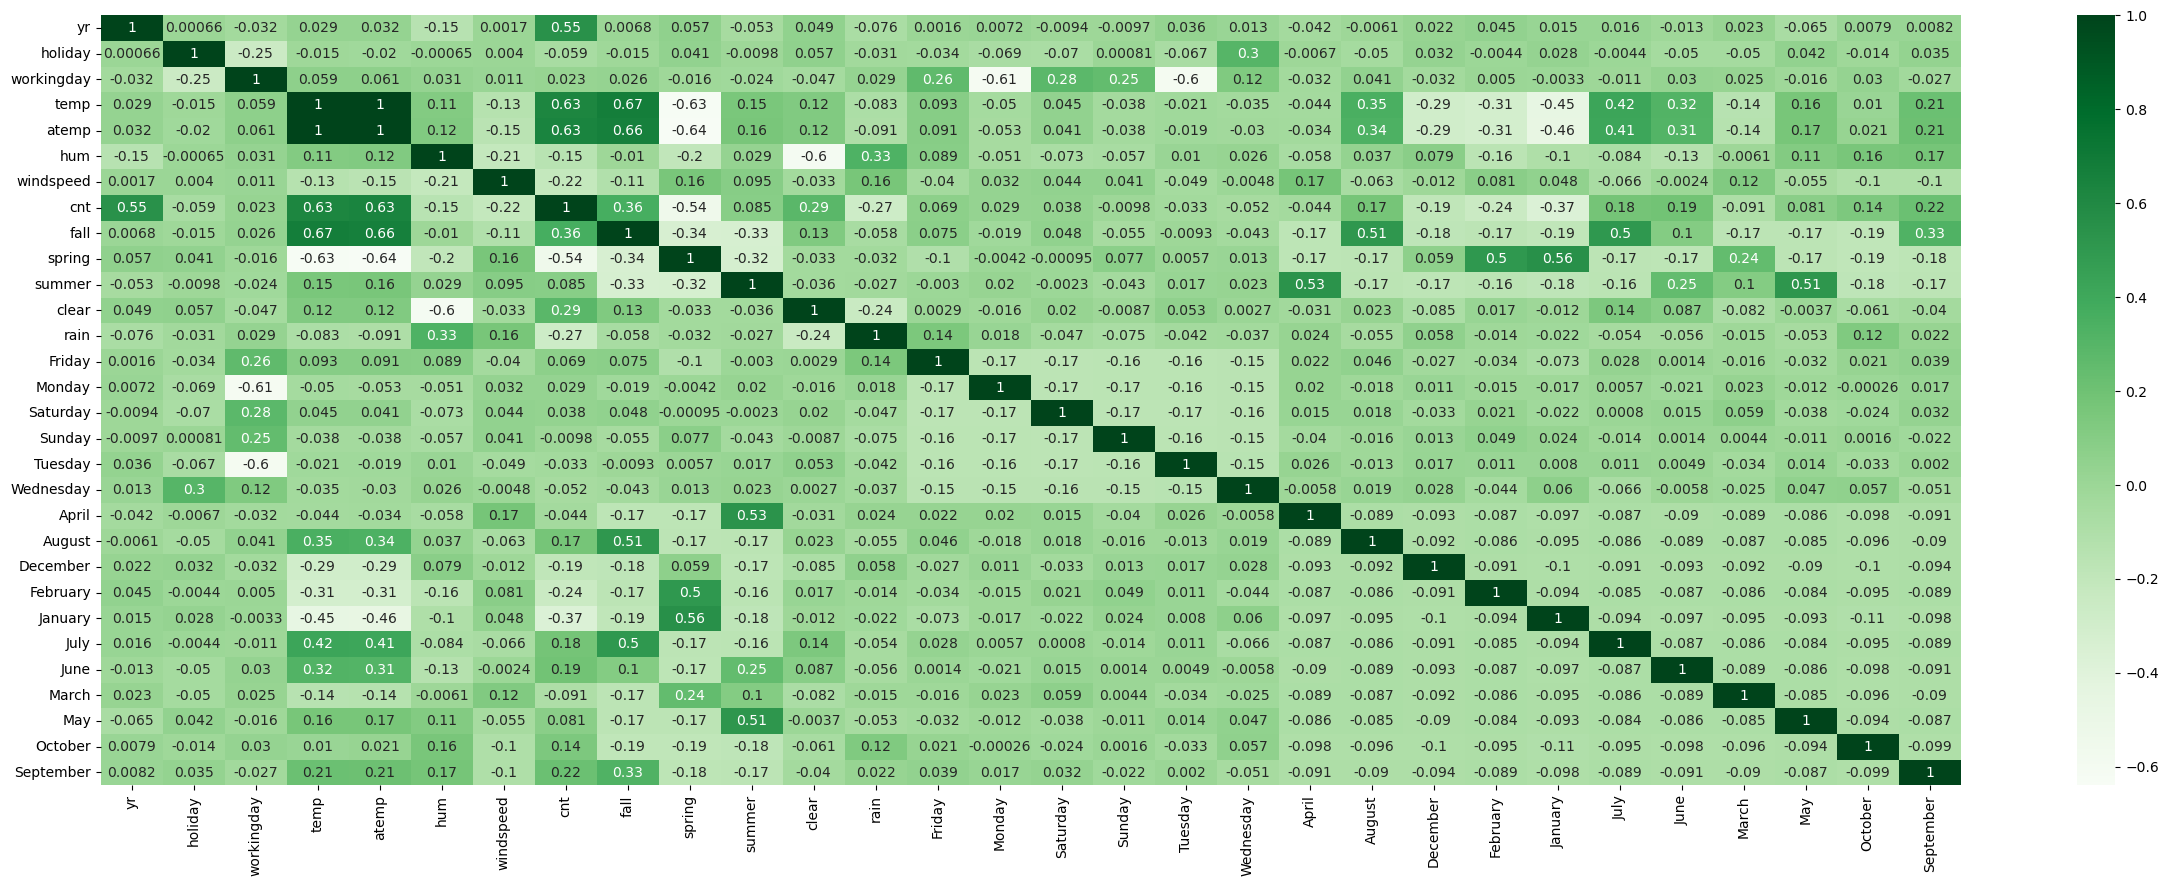

In [50]:
plt.figure(figsize=(30,10))
sns.heatmap(df_train.corr(), annot=True, cmap='Greens')

### Variables related with cnt
+vely strong (> ~0.5): temp, atemp, casual, registered, fall

+vely medium (> ~0.2): workingday, clear, august, july, june, may

-vely strong (< ~-0.5): spring, January

-vely medium (< ~-0.2): windspeed, February, march

Note: see that temp and atemp are very strongly co-related, hence, evetually we should have only one of these variables in the final models

In [51]:
y_train = df_train.pop('cnt')
X_train = df_train
y_test = df_test.pop('cnt')
X_test = df_test

In [52]:
print(X_train.columns)
print(X_test.columns)

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'fall', 'spring', 'summer', 'clear', 'rain', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Tuesday', 'Wednesday', 'April', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'October', 'September'],
      dtype='object')
Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'fall', 'spring', 'summer', 'clear', 'rain', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Tuesday', 'Wednesday', 'April', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'October', 'September'],
      dtype='object')


In [53]:
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select=12)
rfe = rfe.fit(X_train, y_train)

In [54]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('fall', False, 5),
 ('spring', True, 1),
 ('summer', False, 6),
 ('clear', False, 3),
 ('rain', True, 1),
 ('Friday', False, 15),
 ('Monday', True, 1),
 ('Saturday', False, 17),
 ('Sunday', False, 16),
 ('Tuesday', True, 1),
 ('Wednesday', False, 13),
 ('April', False, 10),
 ('August', False, 8),
 ('December', False, 14),
 ('February', False, 11),
 ('January', False, 12),
 ('July', False, 18),
 ('June', False, 9),
 ('March', False, 4),
 ('May', False, 7),
 ('October', False, 2),
 ('September', True, 1)]

In [55]:
selected_columns = X_train.columns[rfe.support_]

In [56]:
selected_columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'spring', 'rain', 'Monday', 'Tuesday', 'September'],
      dtype='object')

In [57]:
def model(y, X, drop_column=None, const=False):
    drop_X = this_X = X
    if drop_column:
        this_X = drop_X = this_X.drop([drop_column], axis=1)
    if const:
        this_X = sm.add_constant(drop_X)
    lm = sm.OLS(y, this_X).fit()
    return lm, drop_X

def get_vif(X):
    vif = pd.DataFrame()
    this_X = X
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(this_X.values, i) for i in range(this_X.shape[1])]
    vif.VIF = round(vif.VIF, 2)
    vif.sort_values(by='VIF', ascending=False)
    return vif

def equation(model):
    intercept = model.params.const
    coeffs = model.params.drop('const')
    equation = f'y = {intercept:.2f}'
    for var, coef in coeffs.items():
        equation += f' + {coef:.2f} * {var}'
    return equation

In [58]:
lm_t, X_train_t = model(y_train, X_train[selected_columns], const=True)
lm2 = lm_t
X_train_2 = X_train_p = X_train_t
print(lm_t.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     203.2
Date:                Wed, 29 May 2024   Prob (F-statistic):          3.86e-176
Time:                        22:25:52   Log-Likelihood:                 473.76
No. Observations:                 510   AIC:                            -923.5
Df Residuals:                     498   BIC:                            -872.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3134      0.022     14.075      0.0

In [59]:
lm_t, X_train_t = model(y_train, X_train_p, 'holiday', True)
lm3 = lm_t
X_train_3 = X_train_p = X_train_t
print(lm_t.summary())
print(get_vif(X_train_t))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     203.2
Date:                Wed, 29 May 2024   Prob (F-statistic):          3.86e-176
Time:                        22:25:52   Log-Likelihood:                 473.76
No. Observations:                 510   AIC:                            -923.5
Df Residuals:                     498   BIC:                            -872.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3499      0.037      9.338      0.0

In [60]:
lm_t, X_train_t = model(y_train, X_train_p, 'Tuesday', True)
lm4 = lm_t
X_train_4 = X_train_p = X_train_t
print(lm_t.summary())
print(get_vif(X_train_t))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     223.4
Date:                Wed, 29 May 2024   Prob (F-statistic):          4.02e-177
Time:                        22:25:52   Log-Likelihood:                 473.28
No. Observations:                 510   AIC:                            -924.6
Df Residuals:                     499   BIC:                            -878.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3731      0.029     12.955      0.0

In [61]:
# removing temp out of temp and atemp because temp has a higher p-value than atemp
lm_t, X_train_t = model(y_train, X_train_p, 'temp', True)
lm5 = lm_t
X_train_5 = X_train_p = X_train_t
print(lm_t.summary())
print(get_vif(X_train_t))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     245.4
Date:                Wed, 29 May 2024   Prob (F-statistic):          3.95e-177
Time:                        22:25:52   Log-Likelihood:                 470.45
No. Observations:                 510   AIC:                            -920.9
Df Residuals:                     500   BIC:                            -878.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3847      0.029     13.496      0.0

In [62]:
# though atemp has higher vif than hum, dropping hum as atemp has a higher co-relation with cnt as can be seen from the heatmap
lm_t, X_train_t = model(y_train, X_train_p, 'hum', True)
lm6 = lm_t
X_train_6 = X_train_p = X_train_t
print(lm_t.summary())
print(get_vif(X_train_t))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     236.3
Date:                Wed, 29 May 2024   Prob (F-statistic):          1.16e-164
Time:                        22:25:52   Log-Likelihood:                 438.23
No. Observations:                 510   AIC:                            -858.5
Df Residuals:                     501   BIC:                            -820.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2344      0.023     10.086      0.0

In [63]:
# though atemp has higher vif than windspeed, dropping windspeed as atemp has a higher co-relation with cnt as can be seen from the heatmap
lm_t, X_train_t = model(y_train, X_train_p, 'windspeed', True)
lm7 = lm_t
X_train_7 = X_train_p = X_train_t
print(lm_t.summary())
print(get_vif(X_train_t))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     262.5
Date:                Wed, 29 May 2024   Prob (F-statistic):          2.89e-163
Time:                        22:25:52   Log-Likelihood:                 432.07
No. Observations:                 510   AIC:                            -848.1
Df Residuals:                     502   BIC:                            -814.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1987      0.021      9.410      0.0

In [64]:
# continuing to drop workingday as it has a vif > 4 and p-value > 0.003 to see if it can build a better model
lm_t, X_train_t = model(y_train, X_train_p, 'workingday', True)
lm8 = lm_t
X_train_8 = X_train_p = X_train_t
print(lm_t.summary())
print(get_vif(X_train_t))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     299.9
Date:                Wed, 29 May 2024   Prob (F-statistic):          1.41e-162
Time:                        22:25:53   Log-Likelihood:                 427.51
No. Observations:                 510   AIC:                            -841.0
Df Residuals:                     503   BIC:                            -811.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2281      0.019     12.086      0.0

In [65]:
# continuing to drop Monday based to higher p-value than others to see it can build a better model
lm_t, X_train_t = model(y_train, X_train_p, 'Monday', True)
lm9 = lm_t
X_train_9 = X_train_p = X_train_t
print(lm_t.summary())
print(get_vif(X_train_t))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     356.1
Date:                Wed, 29 May 2024   Prob (F-statistic):          8.30e-163
Time:                        22:25:53   Log-Likelihood:                 425.01
No. Observations:                 510   AIC:                            -838.0
Df Residuals:                     504   BIC:                            -812.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2350      0.019     12.576      0.0

In [66]:
# studying models lm7, lm8 and lm9

In [67]:
const = True
lm_s = lm9
X_train_t = X_train_9
if const:
    X_train_s = sm.add_constant(X_train_t)
else:
    X_train_s = X_train_t
cols = X_train_t.columns
X_train_sm = X_train_s
y_train_pred = lm_s.predict(X_train_sm)
y_train_pred

352    0.340152
528    0.751919
634    0.815935
220    0.571068
343    0.332586
         ...   
679    0.653233
323    0.431919
671    0.602241
626    0.780728
669    0.626259
Length: 510, dtype: float64

<Axes: ylabel='Density'>

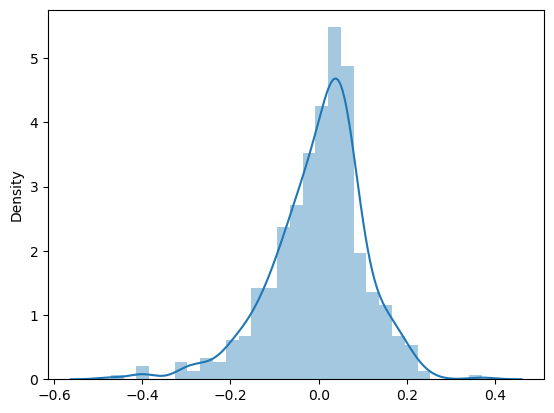

In [68]:
res = y_train - y_train_pred
sns.distplot(res)

In [69]:
X_test_sm = X_test[cols]
if const:
    X_test_sm = sm.add_constant(X_test_sm)
X_test_sm.head()

,const,yr,atemp,spring,rain,September
702,1.0,1,0.511907,0,0,0
201,1.0,0,0.980934,0,0,0
473,1.0,1,0.543400,0,0,0
294,1.0,0,0.454726,0,0,0
547,1.0,1,0.817730,0,0,0


In [70]:
y_test_pred = lm_s.predict(X_test_sm)
print('R-Squared on y-test:', r2_score(y_true=y_test, y_pred=y_test_pred))
print('Equation:', equation(lm_s))

R-Squared on y-test: 0.792343446680177
Equation: y = 0.23 + 0.24 * yr + 0.40 * atemp + -0.17 * spring + -0.26 * rain + 0.07 * September


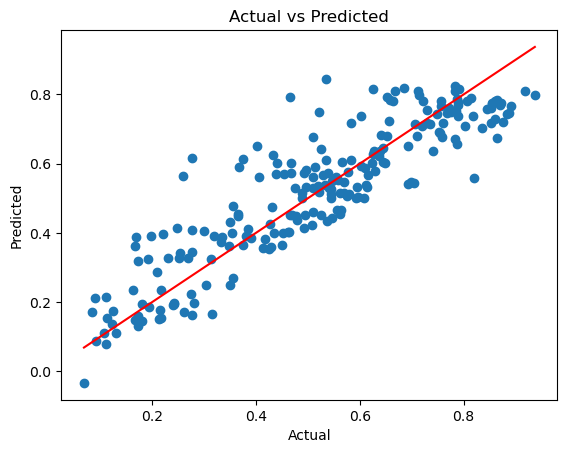

In [71]:
plt.scatter(x=y_test, y=y_test_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.show()

| Model | Train R-Squared | Test R-Squared | Equation |
|----------|----------|----------|----------|
|   lm7  |   .785  |   .799  |   y = 0.20 + 0.24 * yr + 0.04 * workingday + 0.40 * atemp - 0.17 * spring - 0.27 * rain + 0.06 * Monday + 0.07 * September  |
|   lm8  |   .782  |   .789  |   y = 0.23 + 0.24 * yr + 0.40 * atemp - 0.17 * spring - 0.26 * rain + 0.03 * Monday + 0.06 * September  |
|   lm9  |   .779  |   .792  |   y = 0.23 + 0.24 * yr + 0.40 * atemp - 0.17 * spring - 0.26 * rain + 0.07 * September|

Choose lm9 as it is a simpler model (has less variables) and has a high R-Squared value (>70%) for both Train and Test data sets

The top 3 features would be:
1. atemp
2. rain (derived from weathersit, where weathersit=3)
3. yr